# Preprocessing
### Imports

New Python versions sometimes require some extra installations found in the code below

In [1]:
!pip install standard-sunau standard-aifc

In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch.utils.data import DataLoader, Dataset
# Utils
import numpy as np
from numpy import ndarray
import logging
# Base Scripts
from Libraries.Utils import *
from Conf import *


### Config

In [2]:
remote_kernel: bool = False
training_data_name: str = "training_full_low_res"
n_samples: int = 10000
overlap: int = 1
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Processing

In [3]:
filenames = get_filenames_from_folder(path_to_remote_path(DATA_PATH, remote_kernel), "wav")
data: list = []
remaining_samples: int = n_samples
for i in range(len(filenames)):
    file = load_audio_file(os.path.join(path_to_remote_path(DATA_PATH, remote_kernel), filenames[i]), SAMPLE_RATE, True)
    file = split_audiofile(file, TIME_FRAME_S, SAMPLE_RATE, overlap)
    file = audio_splits_to_spectograms(file, LEN_FFT, LEN_HOP)
    data.append(file)
    if file.shape[0] < remaining_samples:
        remaining_samples -= file.shape[0]
    else: break

data: ndarray = np.vstack(data)
data = normalize_filewise(data, -1, 1)
data = dimension_for_VAE(data)[:n_samples]
logger.info(f"Processed data of shape: {data.shape}")

2025-03-09 21:08:07,196 - LIGHT_DEBUG - Got filenames ['Am Bach 2024.wav', 'Cutting Mixes mix.wav', 'DA2407_ADO.wav'] from ../Data
2025-03-09 21:08:34,790 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-03-09 21:08:35,120 - LIGHT_DEBUG - Split audio to: (2519, 128000)
2025-03-09 21:08:35,174 - LIGHT_DEBUG - Started STFT on splits


2025-03-09 21:08:51,000 - LIGHT_DEBUG - Processed Splits: 2510


2025-03-09 21:08:52,497 - LIGHT_DEBUG - Created spectograms of splits: (2519, 241, 445)
2025-03-09 21:09:05,499 - LIGHT_DEBUG - Loaded audio form ../Data\Cutting Mixes mix.wav of dimensions: (192650642,), sr: 32000
2025-03-09 21:09:05,777 - LIGHT_DEBUG - Split audio to: (2006, 128000)
2025-03-09 21:09:05,820 - LIGHT_DEBUG - Started STFT on splits


2025-03-09 21:09:13,000 - LIGHT_DEBUG - Processed Splits: 2000


2025-03-09 21:09:14,646 - LIGHT_DEBUG - Created spectograms of splits: (2006, 241, 445)
2025-03-09 21:09:38,991 - LIGHT_DEBUG - Loaded audio form ../Data\DA2407_ADO.wav of dimensions: (246022144,), sr: 32000
2025-03-09 21:09:39,415 - LIGHT_DEBUG - Split audio to: (2562, 128000)
2025-03-09 21:09:39,516 - LIGHT_DEBUG - Started STFT on splits


2025-03-09 21:09:49,000 - LIGHT_DEBUG - Processed Splits: 2560


2025-03-09 21:09:50,077 - LIGHT_DEBUG - Created spectograms of splits: (2562, 241, 445)
2025-03-09 21:09:55,644 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-03-09 21:09:56,037 - INFO - Processed data of shape: (7087, 224, 416)


### Saving

In [4]:
save_training_data(data, f"{path_to_remote_path(DATA_PATH, remote_kernel)}/{training_data_name}.npy")

2025-03-09 21:11:19,477 - LIGHT_DEBUG - Saved ndarray to:../Data/training_full_low_res.npy


### Test Blocks

In [10]:
print(np.min(file[235]), np.max(file[134]))

-1.0 1.0


In [ ]:
file = load_audio_file(os.path.join(path_to_remote_path(DATA_PATH, remote_kernel), filenames[0]), SAMPLE_RATE, True)
file = split_audiofile(file, TIME_FRAME_S, SAMPLE_RATE, overlap)

2025-03-05 19:21:15,241 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-03-05 19:21:15,616 - LIGHT_DEBUG - Split audio to: (2519, 128000)


2025-03-05 21:15:01,101 - LIGHT_DEBUG - Started STFT
2025-03-05 21:15:01,108 - LIGHT_DEBUG - Created spectogram: (241, 445)


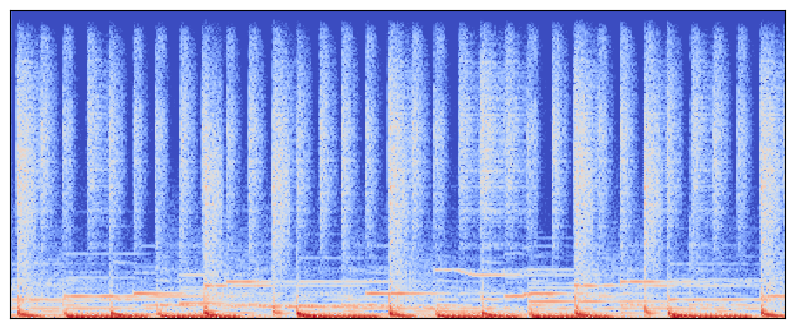

2025-03-05 21:15:01,284 - LIGHT_DEBUG - Started GL
2025-03-05 21:15:01,616 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-03-05 21:15:01,617 - LIGHT_DEBUG - Reconstructed audio: (127872,)
2025-03-05 21:15:01,619 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-03-05 21:15:01,626 - LIGHT_DEBUG - Saved file to:../Results/low_res.wav


In [ ]:
spec = audio_to_spectrogram(file[20], 480, 288, True)
#file = normalize(file, -1, 1)
visualize_spectogram(spec)
save_audio_file(spectrogram_to_audio(spec, 480, 288, SAMPLE_RATE), "../Results/low_res.wav", sample_rate=SAMPLE_RATE)